In [1]:
import anndata
import scanpy as sc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from keras.callbacks import EarlyStopping
import seaborn as sb
from scipy.spatial.distance import pdist

adata = sc.read('/tmp/work/RCproject_code/sce_export.h5ad')

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2024-10-20 19:12:26.844499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `a

In [2]:
#params

simplifly_categories = True

In [70]:
# generate numerical values for each batch category
from sklearn.preprocessing import LabelEncoder
# set up categories variable
categories = adata.obs['batch']

#collpse the categories to microARRAY vs sequencing

if simplifly_categories:
    category_map = {'GSE133057': 'micro', 'GSE145037': 'micro', 'GSE150082': 'micro','GSE190826':'seq1','GSE209746':'seq2',
                    'GSE45404_GPL1': 'micro', 'GSE45404_GPL2': 'micro', 'GSE93375': 'micro','GSE94104': 'micro'}
    categories = np.vectorize(category_map.get)(categories)
    
# Create a LabelEncoder instance
label_encoder = LabelEncoder()
# Fit and transform the categories to integers
numerical_categories = label_encoder.fit_transform(categories)
numerical_categories.shape

(450,)

In [4]:
#normalizaiton
gene_expression_data = adata.layers['logcounts']
from sklearn.preprocessing import MinMaxScaler
# Min-max normalization
scaler = MinMaxScaler()
gene_expression_data = scaler.fit_transform(gene_expression_data)
number_samples = adata.shape[0]
number_genes = adata.shape[1]
input_dim = number_genes

In [5]:
input_shape = (12165,)  # Set to match your actual data
encoding_dim = 64  # Output dimension

In [6]:
from keras import layers, models

# Define the input shape
input_shape = (12165,)  # Number of genes

# Define the encoder function
def build_encoder():
    model = models.Sequential()
    model.add(layers.Input(shape=(12165,)))  # Input shape matches your data

    # First layer with dropout
    model.add(layers.Dense(512, activation='linear'))  # Increased units
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))  # Add dropout for regularization

    # Second layer
    model.add(layers.Dense(256, activation='linear'))  # Increased units
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))  # Add dropout

    # Third layer
    model.add(layers.Dense(128, activation='linear'))  # Increased units
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))  # Add dropout

    # Encoded representation layer
    model.add(layers.Dense(64, activation='linear'))  # Output encoded representation
    return model

# Define the decoder function (adjusted as discussed)
def build_decoder():    
    model = models.Sequential()
    model.add(layers.Input(shape=(64,)))  # Input shape should match the output of the encoder
    model.add(layers.Dense(128, activation='linear'))  
    model.add(layers.LeakyReLU())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='linear'))  
    model.add(layers.LeakyReLU())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(12165, activation='sigmoid'))  # Output layer should match the input shape of the original data
    return model

In [7]:
def build_domain_classifier(input_shape, num_domains):
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    #Increased capacity with more units and layers
    model.add(layers.Dense(256, activation='relu'))  # Increased units and changed activation
    model.add(layers.BatchNormalization())
    # model.add(layers.Dropout(0.3))  # Added dropout for regularization
    
    model.add(layers.Dense(128, activation='relu'))  # Increased units
    model.add(layers.BatchNormalization())
    # model.add(layers.Dropout(0.3))  # Added dropout for regularization

    model.add(layers.Dense(64, activation='relu'))  # Increased units
    model.add(layers.BatchNormalization())
    # model.add(layers.Dropout(0.3))  # Added dropout for regularization
    
    model.add(layers.Dense(32, activation='relu'))  # Maintain units
    model.add(layers.BatchNormalization())
    
    # Output layer with softmax activation
    model.add(layers.Dense(num_domains, activation='softmax'))  # num_domains is the number of classes
    
    return model

In [8]:
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_value=1.0, **kwargs):
        self.lambda_value = lambda_value
        super(GradientReversalLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Define custom gradient behavior
        @tf.custom_gradient
        def reverse_gradients(x):
            # Forward pass: output is just the input
            def grad(dy):
                # Gradient computation: reversed and scaled by lambda_value
                return -self.lambda_value * dy
            return x, grad
        
        return reverse_gradients(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({"lambda_value": self.lambda_value})
        return config

In [9]:
# Define the encoder, decoder, and discriminator (assuming these functions are defined as in previous examples)
encoder = build_encoder()  # Assuming build_encoder() is defined
decoder = build_decoder()  # Assuming build_decoder() is defined
discriminator = build_domain_classifier((64,), len(np.unique(categories)))  # Assuming build_domain_classifier() is defined

# Optimizers for each model
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Assuming you have 1000 training samples as an example
num_samples = adata.shape[0]  # Replace this with your actual number of samples
batch_size = 32

# Calculate the number of steps per epoch
num_steps_per_epoch = num_samples // batch_size

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
num_domains = len(np.unique(categories))
X_data = gene_expression_data
y_domains = numerical_categories

reconstruction_losses = []
domain_losses = []
distAvg_values = []
seq1_v_micro_vals = []
seq1_v_seq2_vals = []
seq2_v_micro_vals = []

balance = True

total_reconstruction_loss = 0.0
total_domain_loss = 0.0
num_batches = 0 
epoch_count = 0
current_dist = 0

# Training loop
def time_to_train(max_epochs,lambda_value,freeze_autoencoder = False, freeze_discriminator= True, freeze_encoder=True, training = 'autoencoder'):
    global epoch_count 
    global total_reconstruction_loss
    global total_domain_loss
    global num_batches
    grl = GradientReversalLayer(lambda_value=lambda_value)  # Instantiate GRL
    
    for epoch in range(max_epochs):
        #code for determiniing if the loop should continue
        if epoch > 10:   #allows a running average to be calcualted to prevent unadvised transitions to the next learning phase

            #get the derivative of the domain loss
            x = np.linspace(0, len(domain_losses) - 1, len(domain_losses))
            y = domain_losses  # Some function of x (e.g., sin(x))
            dy_dx = np.diff(y) / np.diff(x)  # Divide by the difference in x for an approximate derivative
            domain_loss_running_avg_der = np.mean(dy_dx[-10:])  # takes the average derivative of the last 10 epochs (otherwise can be somewhat noisy)

            #get the derivative of the reconstruct
            if training == 'fool_disc':
                if domain_losses[-1] > np.log(num_domains):
                    print("Condition met, exiting loop.")  # Print before break
                    break
                else:
                    pass
            if training == 'train_disc':
                if domain_loss_running_avg_der < -0.0000001:
                    pass
                else:
                    print("Condition met, exiting loop.")  # Print before break
                    break

        epoch_count += 1
        
        for step in range(num_steps_per_epoch):
            # Get a batch of data
            batch_indices = []
            if balance == True:   #if true all domains are balanced
                for domain in range(num_domains):
                    domain_indices = np.where(y_domains == domain)[0]
                    domain_batch_indices = np.random.choice(domain_indices, size=batch_size // num_domains, replace=True)
                    batch_indices.append(domain_batch_indices)
            else:
                    all_indices = np.arange(len(y_domains))  # Get all indices
                    # Randomly sample batch_size indices from all available indices
                    domain_batch_indices = np.random.choice(all_indices, size=batch_size, replace=True)
                    batch_indices.append(domain_batch_indices)
    
            X_batch = X_data[np.concatenate(batch_indices)]
            y_true_batch = y_domains[np.concatenate(batch_indices)]
            y_true = tf.keras.utils.to_categorical(y_true_batch, num_classes=num_domains)  # Convert labels to categorical
        
            # Train on reconstruction loss
            with tf.GradientTape(persistent = True) as autoencoder_tape:
                # Encode
                encoded_output = encoder(X_batch, training=True)
    
                # Decode
                decoded_output = decoder(encoded_output, training=True)
    
                # Calculate reconstruction loss
                reconstruction_loss = tf.reduce_mean(tf.square(X_batch - decoded_output))

            if freeze_autoencoder == False:
                # Calculate gradients for encoder and decoder using the same tape
                encoder_gradients = autoencoder_tape.gradient(reconstruction_loss, encoder.trainable_variables)
                decoder_gradients = autoencoder_tape.gradient(reconstruction_loss, decoder.trainable_variables)
        
                #update the encoder and the decoder
                encoder_optimizer.apply_gradients(zip(encoder_gradients, encoder.trainable_variables))
                decoder_optimizer.apply_gradients(zip(decoder_gradients, decoder.trainable_variables))
    
            # Now, train on domain loss using a new tape
            with tf.GradientTape(persistent = True) as discriminator_tape:
    
                # Encode
                encoded_output = encoder(X_batch, training=True)
                
                # Apply gradient reversal
                encoded_output_grl = grl(encoded_output)
    
                # Domain output
                domain_output = discriminator(encoded_output_grl, training=True)
    
                # Calculate domain loss
                domain_loss = tf.keras.losses.categorical_crossentropy(y_true, domain_output)
                domain_loss = tf.reduce_mean(domain_loss)  # Average over the batch
    
            # Calculate gradients for the discriminator and the encdoer
    
            # Only update discriminator if lambda_value is non-positive, essentially freezing the weight updates when lambda is positive
            if freeze_discriminator == False:
                # Update discriminator
                discriminator_gradients = discriminator_tape.gradient(domain_loss, discriminator.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

            if freeze_encoder == False:
                encoder_gradients = discriminator_tape.gradient(domain_loss, encoder.trainable_variables)
                encoder_optimizer.apply_gradients(zip(encoder_gradients, encoder.trainable_variables))

            # Accumulate losses
            total_reconstruction_loss += reconstruction_loss.numpy()
            total_domain_loss += domain_loss.numpy()
            num_batches += 1
    
        # Calculate average losses for the epoch (same as before)
        average_reconstruction_loss = total_reconstruction_loss / num_batches
        average_domain_loss = total_domain_loss / num_batches
    
        # Store average losses
        reconstruction_losses.append(average_reconstruction_loss)
        domain_losses.append(average_domain_loss)

        if epoch_count % 20 == 0:
            encoded_data = encoder.predict(gene_expression_data, verbose = 0)
            current_dist == np.mean(pdist(encoded_data))
            distAvg_values.append(current_dist)

             input_representation = encoded_data

            #caculate the average expression array for the categories of interest
            seq1_mean = np.mean(input_representation[np.where(categories == 'seq1')],axis = 0, keepdims = True)
            seq2_mean = np.mean(input_representation[np.where(categories == 'seq2')],axis = 0, keepdims = True)
            micro_mean = np.mean(input_representation[np.where(categories == 'micro')],axis = 0, keepdims = True)
            #calculate the pearson correlations
            seq1_v_micro, pval = pearsonr(seq1_mean.ravel(), micro_mean.ravel())
            seq1_v_seq2, pval = pearsonr(seq1_mean.ravel(), seq2_mean.ravel())
            seq2_v_micro, pval = pearsonr(seq2_mean.ravel(), micro_mean.ravel())
            #update the appropriate lists
            seq1_v_micro_vals.append(seq1_v_micro)
            seq1_v_seq2_vals.append(seq1_v_seq2)
            seq2_v_micro_vals.append(seq2_v_micro)
            print(f"Epoch {epoch + 1}, Average Reconstruction Loss: {average_reconstruction_loss}")
            print(f"Epoch {epoch + 1}, Average Domain Loss: {average_domain_loss}")
        else:
            #store the values you won't be calcuating - distance and correlation metrcs
            distAvg_values.append(current_dist)
            seq1_v_micro_vals.append(seq1_v_micro)
            seq1_v_seq2_vals.append(seq1_v_seq2)
            seq2_v_micro_vals.append(seq2_v_micro)
            

    low_dimensional_representation = encoder.predict(gene_expression_data, verbose = 0)

    return(low_dimensional_representation)

# trains the autoencoder only, then trains the discriminator only, then alterates in the while loop between gradient reversal and autoencoder training and discriminator training
# while loop will stop once the paraemters stabilize

print('Initial training of the autoencoder (only)')
first_rep = time_to_train(max_epochs=50, lambda_value = -1, freeze_autoencoder = False, freeze_discriminator= True, freeze_encoder=True, training = 'autoencoder')
print('Initial training of the discriminator (only)')
second_rep = time_to_train(max_epochs =50, lambda_value = 1, freeze_autoencoder = True, freeze_discriminator= False, freeze_encoder=True, training = 'train_disc')

# alternate between updating the discriminator and the autoencoder
while epoch_count < 500:
    # beat the discriminator
    print('Fooling the disciminiator')
    low_dimensional_representation = time_to_train(max_epochs =20, lambda_value = 1, freeze_autoencoder = False, freeze_discriminator= True, freeze_encoder=False, training = 'fool_disc')
    pre_epoch_count = epoch_count
    # allow the discriminator to imrpove but freeze the encoder
    print('Learning to distinguish the domains')
    low_dimensional_representation = time_to_train(max_epochs = 20, lambda_value = 1, freeze_autoencoder = True, freeze_discriminator= False, freeze_encoder=True, training = 'train_disc')
    epoch_delta = epoch_count - pre_epoch_count
    if epoch_delta <= 11:  # this means that the benchmarks are reached as soon as possibly for both training types
        break

Initial training of the autoencoder (only)
Epoch 5, Average Reconstruction Loss: 0.018598061933049134
Epoch 5, Average Domain Loss: 1.6563318456922258
Epoch 5, Average Representation Distance: 41.42557956700924
Epoch 10, Average Reconstruction Loss: 0.013293270400858351
Epoch 10, Average Domain Loss: 1.624511648927416
Epoch 10, Average Representation Distance: 26.55044751157963
Epoch 15, Average Reconstruction Loss: 0.011260308345247593
Epoch 15, Average Domain Loss: 1.6184201950118655
Epoch 15, Average Representation Distance: 20.52115389313084
Epoch 20, Average Reconstruction Loss: 0.01011810560511159
Epoch 20, Average Domain Loss: 1.6209516559328352
Epoch 20, Average Representation Distance: 23.43038290220738
Epoch 25, Average Reconstruction Loss: 0.009330426892265677
Epoch 25, Average Domain Loss: 1.634284635611943
Epoch 25, Average Representation Distance: 15.633002606697364
Epoch 30, Average Reconstruction Loss: 0.008723600171062919
Epoch 30, Average Domain Loss: 1.65153784496443

In [97]:
# # encoded_data = encoder.predict(gene_expression_data, verbose = 0)

# # categories.index('seq2')

# # np.where(categories == 'seq2')
# from scipy.stats import pearsonr

# #gene_expression_data
# #low_dimensional_representation

# input_representation = low_dimensional_representation
# seq1_mean = np.mean(input_representation[np.where(categories == 'seq1')],axis = 0, keepdims = True)
# seq2_mean = np.mean(input_representation[np.where(categories == 'seq2')],axis = 0, keepdims = True)
# micro_mean = np.mean(input_representation[np.where(categories == 'micro')],axis = 0, keepdims = True)
# seq1_v_micro, pval = pearsonr(seq1_mean.ravel(), micro_mean.ravel())
# seq1_v_se2, pval = pearsonr(seq1_mean.ravel(), seq2_mean.ravel())
# seq2_v_micro, pval = pearsonr(seq2_mean.ravel(), micro_mean.ravel())


0.43201322339736065
0.6343514246520797
-0.17870134034962082


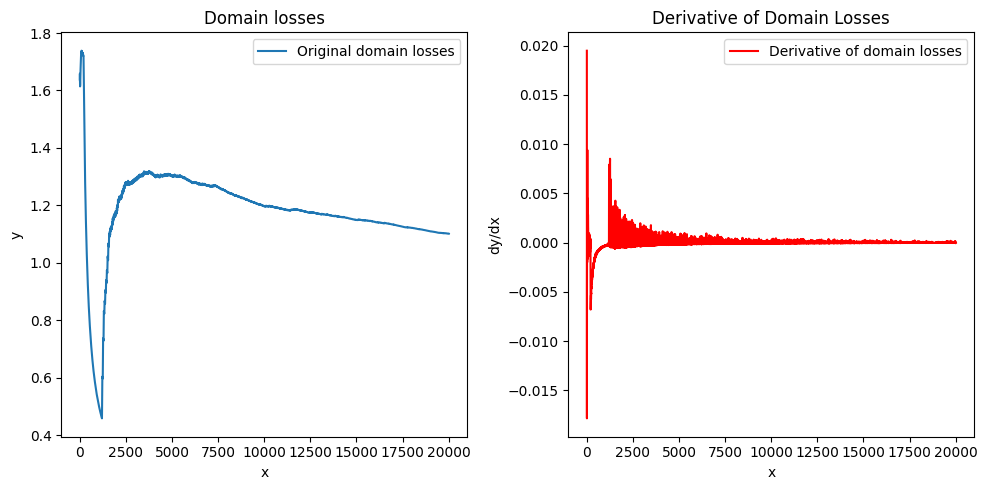

In [23]:
# derivative of the domain losses

x = np.linspace(0, len(domain_losses), len(domain_losses))  # 100 points between 0 and 10
y = domain_losses  # Some function of x (e.g., sin(x))

# Calculate the running derivative using numpy.diff
dy_dx = np.diff(y) / np.diff(x)  # Divide by the difference in x for an approximate derivative

# Plot the original function
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, y, label='Original domain losses')
plt.title('Domain losses')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# For plotting the derivative, adjust x to match the size of the derivative (which has n-1 points)
x_mid = (x[:-1] + x[1:]) / 2  # Midpoints of x for the derivative plot

# Plot the derivative
plt.subplot(1, 2, 2)
plt.plot(x_mid, dy_dx, label='Derivative of domain losses', color='r')
plt.title('Derivative of Domain Losses')
plt.xlabel('x')
plt.ylabel('dy/dx')
plt.legend()

plt.tight_layout()
plt.show()

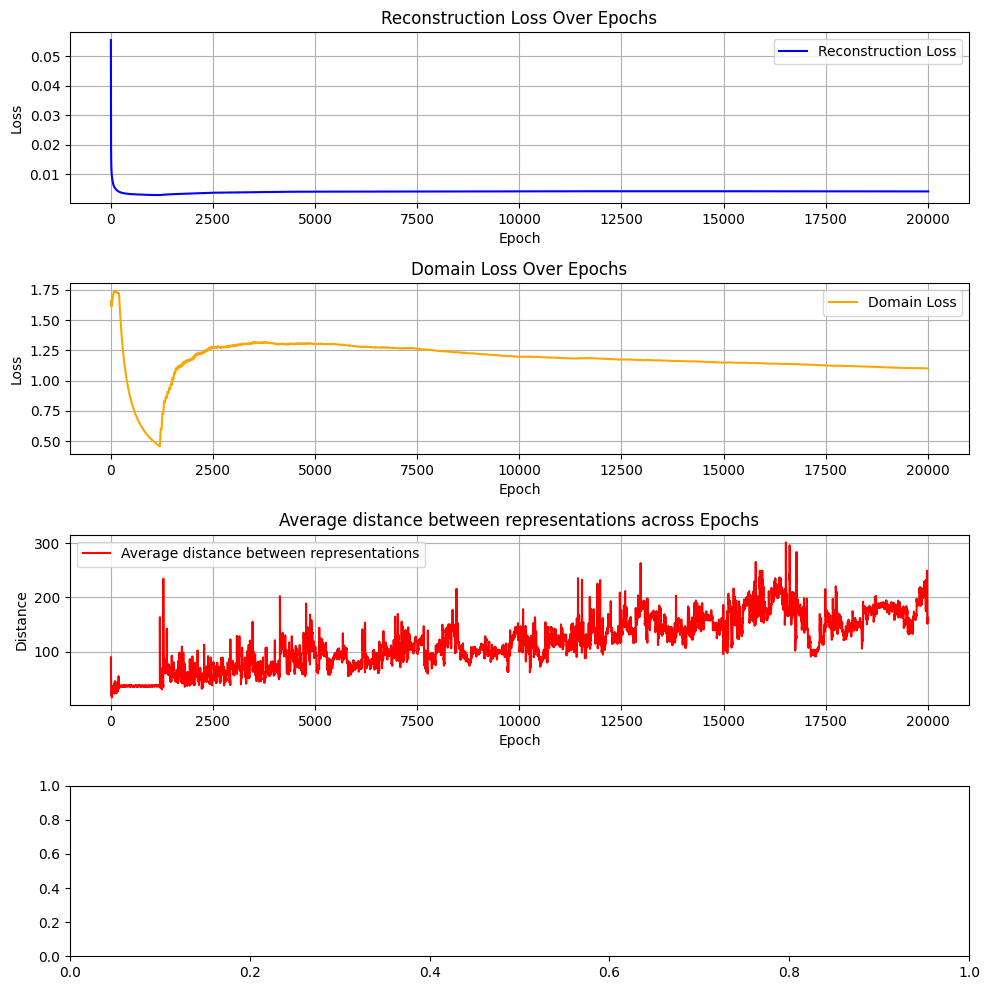

In [99]:
# After training, plot the losses
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

# Plot Reconstruction Loss
axs[0].plot(range(1, len(reconstruction_losses)+1), reconstruction_losses, label='Reconstruction Loss', color='blue')
axs[0].set_title('Reconstruction Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid()
axs[0].legend()

# Plot Domain Loss
axs[1].plot(range(1, len(domain_losses)+1), domain_losses, label='Domain Loss', color='orange')
axs[1].set_title('Domain Loss Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid()
axs[1].legend()

# Plot the average distance values
axs[2].plot(range(1, len(distAvg_values)+1), distAvg_values, label='Average distance between representations', color='red')
axs[2].set_title('Average distance between representations across Epochs')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Distance')
axs[2].grid()
axs[2].legend()


# Plot the Pearson correlations on axs[3]
epochs = range(1, len(seq1_v_micro_vals) + 1)
axs[3].plot(epochs, seq1_v_micro_vals, label='Seq1 vs Microarray', color='red')
axs[3].plot(epochs, seq1_v_seq2_vals, label='Seq1 vs Seq2', color='blue')
axs[3].plot(epochs, seq2_v_micro_vals, label='Seq2 vs Microarray', color='green')
axs[3].set_title('Pearson Correlations between Domains across Epochs')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Correlation')
axs[3].grid()
axs[3].legend()

plt.tight_layout()
plt.show()

In [41]:
low_dimensional_representation.shape

(450, 64)

15/15 [==============================] - 0s 3ms/step
(450, 64)


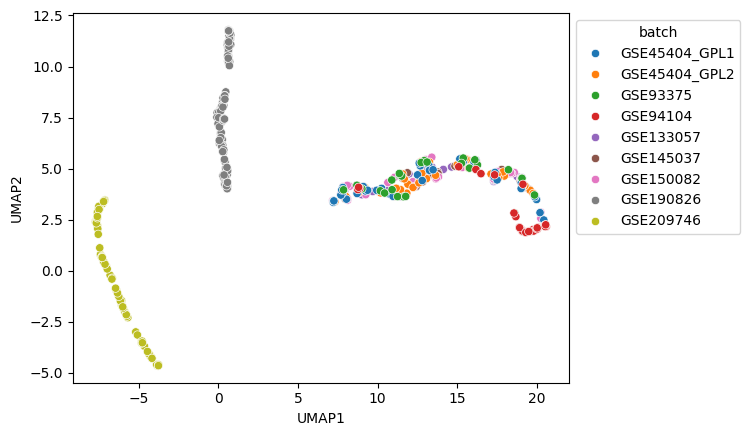

In [34]:
#grab the represetations from the trained model
low_dimensional_representation = encoder.predict(gene_expression_data)

#verify the shape
print(low_dimensional_representation.shape)

#set up the umap

umap_model = umap.UMAP(n_neighbors=15,   # Controls local vs global structure
                        min_dist=0.1,    # Controls how tightly UMAP packs points together
                        metric='euclidean')  # Distance metric to use

umap_result = umap_model.fit_transform(low_dimensional_representation)

#checking batch separation
current_label =  adata.obs['batch']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'batch':current_label}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='batch')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

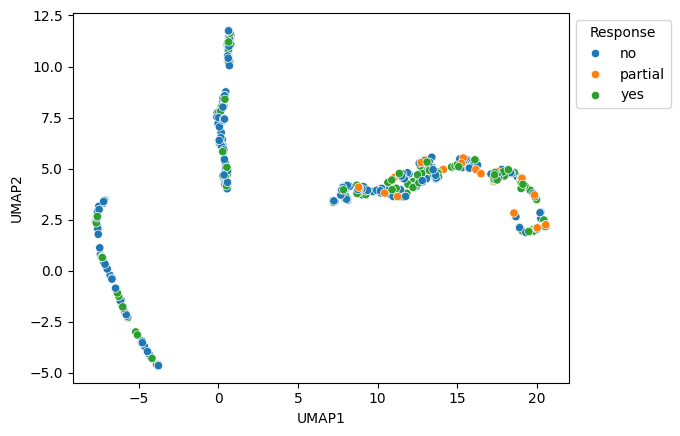

In [35]:
#checking response variable separation
current_label =  adata.obs['Response']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'Response':current_label}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Response')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [36]:
# use the embeddings for random forest classification
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

/tmp/ipykernel_433824/1211444478.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = adata.obs['Response'][indices]


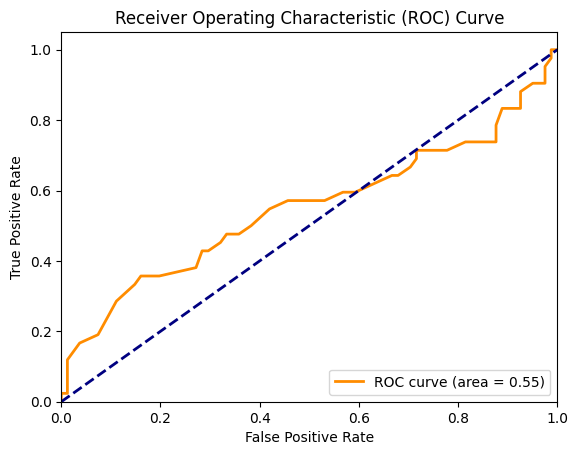

In [37]:
## random forest with original data
indices = [i for i, s in enumerate(adata.obs['Response']) if s in ["yes", "no"]]
y = adata.obs['Response'][indices]
y = [1 if x == "yes" else 0 for x in y]
y = np.array(y)
X = X_data[indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (class 1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

/tmp/ipykernel_433824/1434992043.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = adata.obs['Response'][indices]


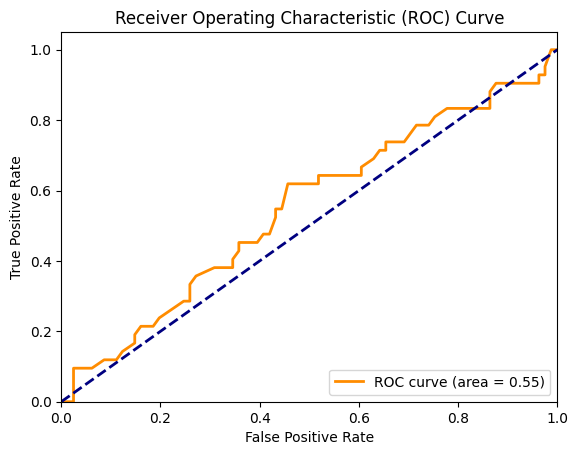

In [38]:
## random forest with transformed data
indices = [i for i, s in enumerate(adata.obs['Response']) if s in ["yes", "no"]]
y = adata.obs['Response'][indices]
y = [1 if x == "yes" else 0 for x in y]
y = np.array(y)
X = low_dimensional_representation[indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (class 1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [31]:
# #set up the umap

# all_sets = np.vstack((first_rep,second_rep,third_rep,low_dimensional_representation))

# umap_model = umap.UMAP(n_neighbors=15,   # Controls local vs global structure
#                         min_dist=0.1,    # Controls how tightly UMAP packs points together
#                         metric='euclidean')  # Distance metric to use

# umap_result = umap_model.fit_transform(all_sets)

# first = np.repeat(1,first_rep.shape[0])
# training_stage = np.concatenate((first,first*2,first*3,first*4))

# #checking batch separation
# current_label =  adata.obs['batch']
# umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'stage':training_stage}
# umap_df = pd.DataFrame(data=umap_data)
# ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='stage')
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [32]:
print('test')

test
